# Project 1 - Cat & Dog Classification
## Introduction

The assigned project involves the modeling and the succeeding training of a deep neural network on a dataset composed of images of cats and dogs in order to discriminate one from the other: indeed, the problem we are facing a binary classification problem.
The nature of the input is an image on: each image of the training, evaluation and test dataset has size [3, 150, 150]. 
In order to measure the success, so the efficiency, of the model, we decided to use the confusion matrix that counts the occurrences of predictions based on true values:


|                 | Predicted: Dog | Predicted: Cat |
|-----------------|----------------|----------------|
| **Actual: Dog** | $n_{dd}$       | $n_{dc}$       |
| **Actual: Cat** | $n_{cd}$       | $n_{cc}$       |
 
where the number of observations of class  for which class  was predicted:
 
$$
n_{kl}= \sum_{i=1}^{n}{(Y_i=k \quad \text{and} \quad \hat{Y}_i=l)} \qquad \quad  k, l \in \{\text{cat}, \text{dog}\}
$$
where:
-   $n$: number of observation (in this context, number of image);

-   $k$: true values;

-   $l$: predicted class.
In the specific case of the binary classification, in which the categorical variable has only two modalities (cat and dog), the values in the confusion matrix would be:

-   $n_{dd}$ and $n_{cc}$: right prediction —\> classified correctly;

-   $n_{dc}$ and $n_{cd}$ wrong prediction —\> mis-classification.

Each image in the training, validation, and test data sets has dimensions of **[3, 150, 150]**, where:

-   The first dimension represents the number of color channels (RGB);

-   The remaining two dimensions define the height and width of the images.

To assess the model's performance, we utilize a **confusion matrix**, which records the number of correct and incorrect predictions based on the true class labels.




## Data Loading and Augmentation

The work begins with **data loading** subdivided in training, evaluation and test data on which to run the network using a **data-loader** because of the high dimension and of the pixel nature of the input. Using the data loader on data set, it’s useful because it will apply the transformations to all images in the batch it loads; Therefore, every time it load the same image, it will be different versions of it. To effectively train the neural network, we partition the data set into three subsets:\
- **Training set** – Used to train the model.\
- **Validation set** – Used to fine-tune hyper parameters and prevent over fitting.\
- **Test set** – Used to evaluate the final model's generalization capability.

In order to make the model as efficient as possible and being able to predict the true class, **data augmentation** techniques are used such that even a little modification of the image doesn’t affect the result of the model and also to allow a more and better generalization of the model. For a classification task it’s easier because the goal of a classifier is to be invariant to a wide variety of transformations: we can generate new   pairs easily just by transforming the inputs in our training set. In the case of the project, for the training data we tried different transformations and after different experiments, we opted for:

-   A **rotation** of the input data of 15 degrees;

-   A **zoom** between 80% and 120%;

-   An **horizontal flip**.

Regarding the validation and test data, these, along with the training input after data augmentation, are subject to image resizing to the original size in order to correctly perform calculation in the model and a normalization of all data. 

After analysis, we confirmed that the training (2,000 images), validation (600 images), and test (400 images) sets are evenly distributed between cats and dogs.

In [3]:
# Import necessary libraries
pip install torch seaborn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

# Define transformations:convert to tensor
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees = 15, scale = (0.8, 1.2)), # rotate of 15 degrees and zoom from 80 to 120%
    transforms.RandomHorizontalFlip(),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load train dataset
train_dataset = datasets.ImageFolder(root="/Users/dmensorio/Desktop/Università Daniele/Third Year/AI506 - Advanced Machine Learning/projects/project 1/catdog_data/train", 
                                    transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load test dataset
test_dataset = datasets.ImageFolder(root="/Users/dmensorio/Desktop/Università Daniele/Third Year/AI506 - Advanced Machine Learning/projects/project 1/catdog_data/test", 
                                    transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load validation dataset
val_dataset = datasets.ImageFolder(root="/Users/dmensorio/Desktop/Università Daniele/Third Year/AI506 - Advanced Machine Learning/projects/project 1/catdog_data/validation", 
                                    transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Check class mapping
print(train_dataset.class_to_idx)  # {'cats': 0, 'dogs': 1}

image, label = train_dataset[0]
# Check the size of the image
print("Image Size:", image.shape)
#check the label
print(train_dataset.classes) 
print(train_dataset.class_to_idx)


SyntaxError: invalid syntax (150615593.py, line 2)

Train dataset size: 2000, Test dataset size: 400, Validation dataset size: 600


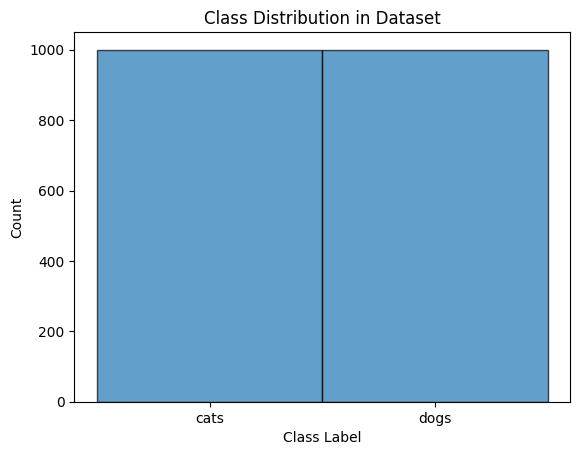

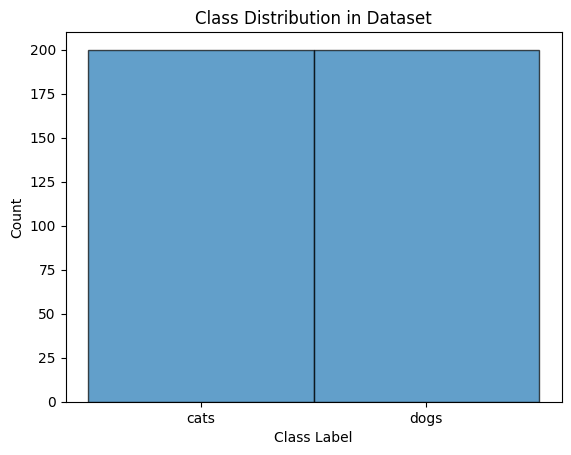

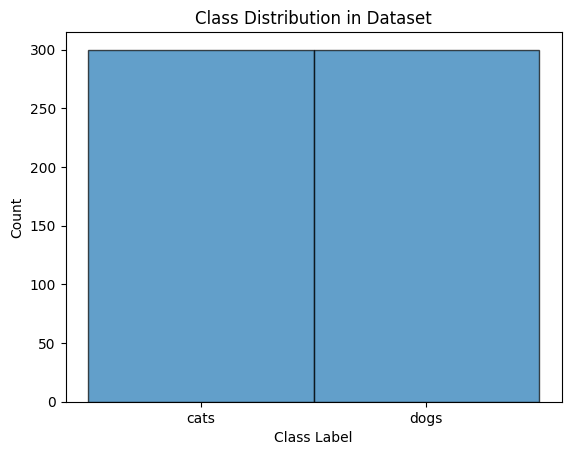

In [247]:
import numpy as np
import matplotlib.pyplot as plt

# Fix for dataset size and distribution plot
print(f"Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}, Validation dataset size: {len(val_dataset)}")

def plot_class_distribution(dataset):
    labels = np.array(dataset.targets)  # Convert list to numpy array
    plt.hist(labels, bins=np.arange(len(dataset.classes) + 1) - 0.5, edgecolor='black', alpha=0.7)
    plt.xticks(range(len(dataset.classes)), dataset.classes)
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title("Class Distribution in Dataset")
    plt.show()

plot_class_distribution(train_dataset)
plot_class_distribution(test_dataset)
plot_class_distribution(val_dataset)

## Model Definition

Since the input data is made of grid-like topology (image), we choose to implement a **Convolutional Neural Network** (CNN), instead of a deep feedforward neural network, for this binary image classification. This CNN model is made of :

-   two **constitutional layers**: each constitutional layer has a kernel size of 3x3 with padding 1 that is used to maintain the dimension of the original data;

-   a **pooling layer**: in this model, we could decide, depending on performance and result, to use an Average Polling or a Max Pooling layer with different window size (different kernel and stride size) ;

-   Two **Fully Connected layers**: the first FC layer transform the feature maps into a 128-dimensional representation, the second one, instead, maps this to two output neurons, one for each class of the problem (cat or dog);

-   A **dropout layer** (if employed: it will be discussed successively): added before the first fully connected layer in order to prevent data over-fitting, randomly disabling neurons during training; a dropout rate could be chosen;

-   A **ReLU activation function**: it is applied after constitutional and fully connected layers to introduce non-linearity in the model.


In [248]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.1, pool_type="max", pool_kernel=2, pool_stride=2):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        if pool_type == "max":
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == "avg":
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            print("choose between max and avg pooling!")

        # Fully connected layers
        if pool_kernel == 2 and pool_stride == 2:
            self.fc1 = nn.Linear(64 * 37 * 37, 128)
        elif pool_kernel ==3 and pool_stride == 2:
            self.fc1 = nn.Linear(64 * 36 * 36, 128)
        elif pool_kernel == 3 and pool_stride == 3:
            self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, 2)  # 2 output classes (cats & dogs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Train the CNN Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#trying different pooling layers
model = CNN().to(device) #with max pooling
model_w_avgpool = CNN(pool_type="avg").to(device) # with avergaing pooling
model_w_3x2kmaxpool = CNN(pool_kernel=3, pool_stride=2).to(device) # with max pooling with kernel 3 and stride 2
model_w_3x3kmaxpool = CNN(pool_kernel=3, pool_stride=3).to(device) # with max pooling with kernel 3 and stride 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005) #already tried with 0.001 maybe too high. trying with 0.0005

best_loss=float('inf')
epochs_without_improvement=0

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, patience=3, regularization_type, lambda_val=0.01):
    train_losses = []  
    val_losses = []  
    val_accuracies = []   
    best_loss = float('inf')  
    epochs_without_improvement = 0  
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        
        # Training 
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  
            outputs = model(images)
            loss = criterion(outputs, labels) 

            # Regularization
            if regularization_type == 'L1':
                l1_reg = lambda_val * torch.norm(model.fc2.weight, 1)
                loss += l1_reg
            elif regularization_type == 'L2':
                l2_reg = lambda_val * torch.norm(model.fc2.weight, 2)
                loss += l2_reg
        
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))  

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%')

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break  

    return train_losses, val_losses, val_accuracies

## Scaling up of the model 

If we try to run the training data on this raw model the accuracy of the validation and test data set are not as efficient as possible: they are around 60%. So, in order to improve accuracy, we try to experiment with different configurations on different levels:

-   **experiment with different pooling layers**: we have four different options:

    -   Max pooling;

    -   Average pooling;

    -   Max pooling with kernel size equals to 3 and stride size equals to 2;

    -   Max pooling with kernel size equals to 3 and stride size equals to 3.

In [253]:
# train model with different pooling layers
models = [
    ('Max Pooling', model),
    ('Avg Pooling', model_w_avgpool),
    ('3x2 Kernel Max Pooling', model_w_3x2kmaxpool),
    ('3x3 Kernel Max Pooling', model_w_3x3kmaxpool)
]

train_losses_dict = {}
val_losses_dict = {}
val_accuracies_dict = {}

for model_name, model_instance in models:
    print(f"Training {model_name}...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_instance.parameters(), lr=0.0005)
    
    train_losses, val_losses, accuracy = train_model(model_instance, train_loader, val_loader, criterion, optimizer, epochs=50)
    train_losses_dict[model_name] = train_losses
    val_losses_dict[model_name] = val_losses
    val_accuracies_dict[model_name] = accuracy



Training Max Pooling...
Epoch 1, Training Loss: 0.5404, Validation Loss: 0.6006, Validation Accuracy: 70.00%
Epoch 2, Training Loss: 0.5107, Validation Loss: 0.5828, Validation Accuracy: 71.33%
Epoch 3, Training Loss: 0.5019, Validation Loss: 0.5562, Validation Accuracy: 73.00%
Epoch 4, Training Loss: 0.4741, Validation Loss: 0.5441, Validation Accuracy: 74.67%
Epoch 5, Training Loss: 0.4724, Validation Loss: 0.5497, Validation Accuracy: 74.83%
Epoch 6, Training Loss: 0.4580, Validation Loss: 0.5618, Validation Accuracy: 73.50%
Epoch 7, Training Loss: 0.4395, Validation Loss: 0.5464, Validation Accuracy: 73.17%
Early stopping triggered at epoch 7.
Training Avg Pooling...
Epoch 1, Training Loss: 0.5892, Validation Loss: 0.6411, Validation Accuracy: 67.00%
Epoch 2, Training Loss: 0.5627, Validation Loss: 0.5995, Validation Accuracy: 68.50%
Epoch 3, Training Loss: 0.5473, Validation Loss: 0.6298, Validation Accuracy: 69.00%
Epoch 4, Training Loss: 0.5416, Validation Loss: 0.6083, Validati

In [ ]:
import pandas as pd

# Create a DataFrame to store results
df_results = pd.DataFrame({
    "Pooling Type": list(train_losses_dict.keys()),
    "Final Train Loss": [losses[-1] for losses in train_losses_dict.values()],
    "Final Validation Loss": [losses[-1] for losses in val_losses_dict.values()],
    "Validation Accuracy (%)": [acc for acc in val_accuracies_dict.values()]
})

# Sort by Validation Accuracy
df_results = df_results.sort_values(by="Validation Accuracy (%)", ascending=False)

# Display table
print(df_results)

# Optionally, display in a more readable format if using Jupyter Notebook
from IPython.display import display
display(df_results)


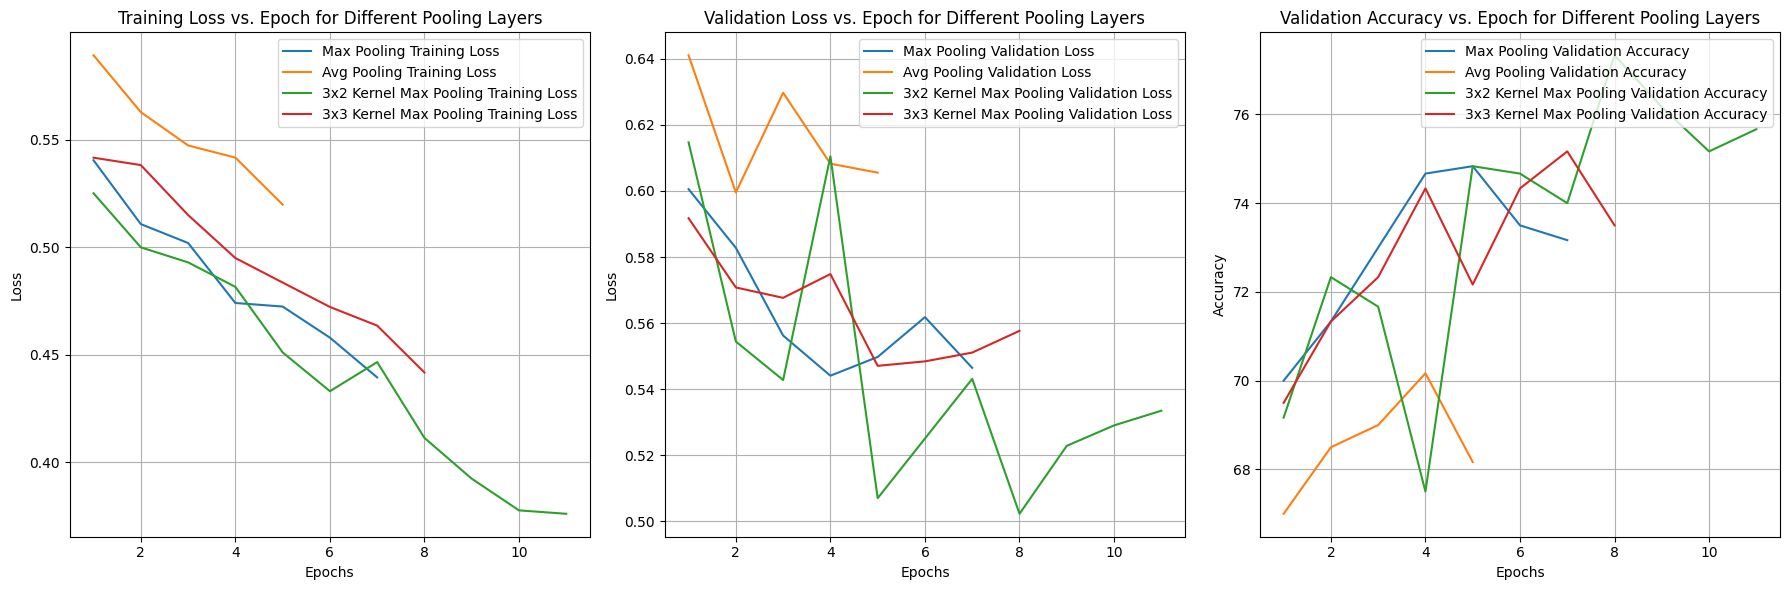

In [254]:
plt.figure(figsize=(18, 6))  

# Training Loss
plt.subplot(131)
for model_name in train_losses_dict:
    plt.plot(range(1, len(train_losses_dict[model_name]) + 1), train_losses_dict[model_name], label=f'{model_name} Training Loss')
plt.title("Training Loss vs. Epoch for Different Pooling Layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)

# Validation Loss
plt.subplot(132)
for model_name in val_losses_dict:
    plt.plot(range(1, len(val_losses_dict[model_name]) + 1), val_losses_dict[model_name], label=f'{model_name} Validation Loss')
plt.title("Validation Loss vs. Epoch for Different Pooling Layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)

# Validation Accuracy
plt.subplot(133)
for model_name in val_accuracies_dict:
    plt.plot(range(1, len(val_accuracies_dict[model_name]) + 1), val_accuracies_dict[model_name], label=f'{model_name} Validation Accuracy')
plt.title("Validation Accuracy vs. Epoch for Different Pooling Layers")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()  
plt.show()

The experiment gives us as the most efficient result the Max Pooling layer with kernel size equals to 3 and the stride size 2, as can be seen in the plot.

- experiment with regularization techniques: we have three different options:
    - Model with no regularization;
    - L1 regularization;
    - L2 regularization.

In [273]:
# Train models with different regularization
model_no_reg = CNN(pool_kernel=3, pool_stride=2).to(device)
model_l1 = CNN(pool_kernel=3, pool_stride=2).to(device)
model_l2 = CNN(pool_kernel=3, pool_stride=2).to(device)

optimizer_no_reg = optim.Adam(model_no_reg.parameters(), lr=0.001)
optimizer_l1 = optim.Adam(model_l1.parameters(), lr=0.001)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=0.001)

reg = [
    ('No Regularization', '', model_no_reg),
    ('L1 Regularization', 'L1', model_l1),
    ('L2 Regularization', 'L2', model_l2)
]

train_losses_dict = {}
val_losses_dict = {}
val_accuracies_dict = {}

for reg_name, reg_instance, model in reg:
    print(f"Training {reg_name}...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, regularization_type = reg_instance, epochs=50)
    
    train_losses_dict[reg_name] = train_losses
    val_losses_dict[reg_name] = val_losses
    val_accuracies_dict[reg_name] = accuracy

Training No Regularization...
Epoch 1, Training Loss: 0.8563, Validation Loss: 0.6928, Validation Accuracy: 50.00%
Epoch 2, Training Loss: 0.6903, Validation Loss: 0.6892, Validation Accuracy: 49.83%
Epoch 3, Training Loss: 0.6828, Validation Loss: 0.6806, Validation Accuracy: 55.00%
Epoch 4, Training Loss: 0.6630, Validation Loss: 0.6786, Validation Accuracy: 57.00%
Epoch 5, Training Loss: 0.6484, Validation Loss: 0.6789, Validation Accuracy: 54.33%
Epoch 6, Training Loss: 0.6350, Validation Loss: 0.6542, Validation Accuracy: 60.00%
Epoch 7, Training Loss: 0.6130, Validation Loss: 0.6311, Validation Accuracy: 67.33%
Epoch 8, Training Loss: 0.5992, Validation Loss: 0.6286, Validation Accuracy: 65.83%
Epoch 9, Training Loss: 0.5747, Validation Loss: 0.6228, Validation Accuracy: 67.00%
Epoch 10, Training Loss: 0.5717, Validation Loss: 0.6054, Validation Accuracy: 66.67%
Epoch 11, Training Loss: 0.5529, Validation Loss: 0.6177, Validation Accuracy: 65.00%
Epoch 12, Training Loss: 0.5485, 

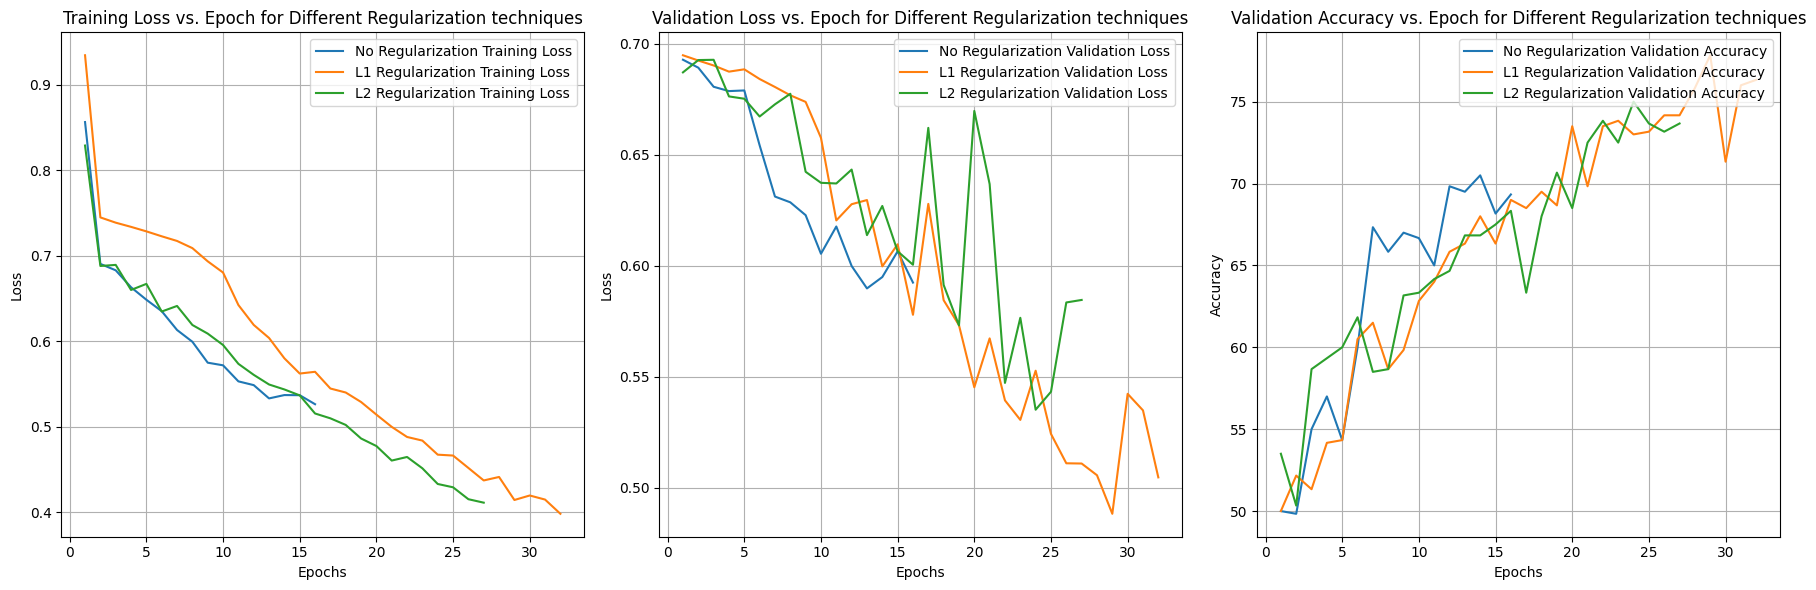

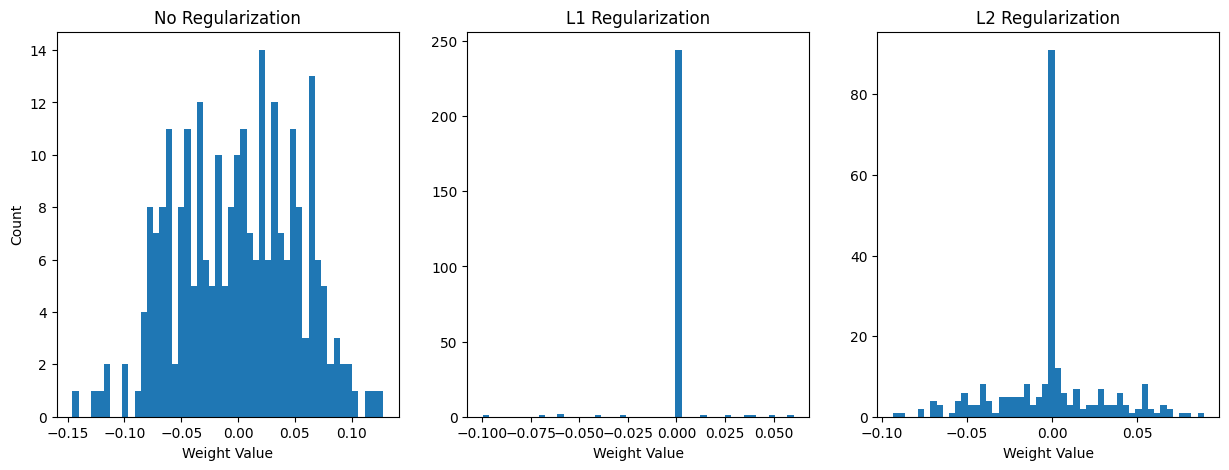

In [274]:
plt.figure(figsize=(18, 6))

# Training Loss
plt.subplot(131)
for reg_name in train_losses_dict:
    plt.plot(range(1, len(train_losses_dict[reg_name]) + 1), train_losses_dict[reg_name], label=f'{reg_name} Training Loss')
plt.title("Training Loss vs. Epoch for Different Regularization techniques")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)

# Validation Loss
plt.subplot(132)
for reg_name in val_losses_dict:
    plt.plot(range(1, len(val_losses_dict[reg_name]) + 1), val_losses_dict[reg_name], label=f'{reg_name} Validation Loss')
plt.title("Validation Loss vs. Epoch for Different Regularization techniques")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)

# Validation Accuracy
plt.subplot(133)
for reg_name in val_accuracies_dict:
    plt.plot(range(1, len(val_accuracies_dict[reg_name]) + 1), val_accuracies_dict[reg_name], label=f'{reg_name} Validation Accuracy')
plt.title("Validation Accuracy vs. Epoch for Different Regularization techniques")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# weight distributions
def plot_weight_distributions():
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.hist(model_no_reg.fc2.weight.detach().cpu().numpy().flatten(), bins=50)
    plt.title('No Regularization')
    plt.xlabel('Weight Value')
    plt.ylabel('Count')

    plt.subplot(132)
    plt.hist(model_l1.fc2.weight.detach().cpu().numpy().flatten(), bins=50)
    plt.title('L1 Regularization')
    plt.xlabel('Weight Value')

    plt.subplot(133)
    plt.hist(model_l2.fc2.weight.detach().cpu().numpy().flatten(), bins=50)
    plt.title('L2 Regularization')
    plt.xlabel('Weight Value')

    plt.show()

plot_weight_distributions()

The experiment gives us as the most efficient result the L1 regularization, as can be seen in the graph.

- experiment with different optimization techniques: we have five different options:
    - Adam optimizer;
    - AdamW optimizer: Adam with weight decay;
    - Stochastic Gradient Descent (SGD): another parameter of a SGD could be the momentum:
        - SGD with momentum 0.0;
        - SGD with momentum 0.9.


In [ ]:
# Train models with different optimizers
model_Adam = CNN(pool_kernel=3, pool_stride=2).to(device)
model_AdamW = CNN(pool_kernel=3, pool_stride=2).to(device)
model_SGD = CNN(pool_kernel=3, pool_stride=2).to(device)
model_SGD_mom00 = CNN(pool_kernel=3, pool_stride=2).to(device)
model_SGD_mom09 = CNN(pool_kernel=3, pool_stride=2).to(device)


optimizer_Adam = optim.Adam(model_Adam.parameters(), lr=0.0005) 
optimizer_AdamW = optim.AdamW(model_AdamW.parameters(), lr=0.0005) 
optimizer_SGD = optim.SGD(model_SGD.parameters(), lr=0.0005) 
optimizer_SGD_mom00 = optim.SGD(model_SGD_mom00.parameters(), lr=0.0005) 
optimizer_SGD_mom09 = optim.SGD(model_SGD_mom09.parameters(), lr=0.0005) 

opt = [
    ('Adam', optimizer_Adam, model_Adam),
    ('AdamW', optimizer_AdamW, model_AdamW),
    ('SGD', optimizer_SGD, model_SGD),
    ('SGD momentum 0.0', optimizer_SGD_mom00, model_SGD_mom00),
    ('SGD momentum 0.9', optimizer_SGD_mom09, model_SGD_mom09)
]

train_losses_dict = {}
val_losses_dict = {}
val_accuracies_dict = {}

for opt_name, optimizer_instance, model in opt:
    print(f"Training {opt_name}...")
    criterion = nn.CrossEntropyLoss()
    
    train_losses, val_losses, accuracy = train_model(model, train_loader, val_loader, criterion, optimizer_instance, regularization_type = 'L1',  epochs=50)
    
    train_losses_dict[opt_name] = train_losses
    val_losses_dict[opt_name] = val_losses
    val_accuracies_dict[opt_name] = accuracy

Training Adam...
Epoch 1, Training Loss: 0.8121, Validation Loss: 0.6625, Validation Accuracy: 61.00%
Epoch 2, Training Loss: 0.6968, Validation Loss: 0.6802, Validation Accuracy: 56.67%
Epoch 3, Training Loss: 0.6428, Validation Loss: 0.6126, Validation Accuracy: 68.00%
Epoch 4, Training Loss: 0.6068, Validation Loss: 0.5790, Validation Accuracy: 71.00%
Epoch 5, Training Loss: 0.5751, Validation Loss: 0.5991, Validation Accuracy: 68.17%
Epoch 6, Training Loss: 0.5492, Validation Loss: 0.5905, Validation Accuracy: 69.17%
Epoch 7, Training Loss: 0.5309, Validation Loss: 0.5636, Validation Accuracy: 71.83%
Epoch 8, Training Loss: 0.5192, Validation Loss: 0.5689, Validation Accuracy: 73.00%
Epoch 9, Training Loss: 0.5106, Validation Loss: 0.6121, Validation Accuracy: 70.50%
Epoch 10, Training Loss: 0.4778, Validation Loss: 0.5362, Validation Accuracy: 74.33%
Epoch 11, Training Loss: 0.4652, Validation Loss: 0.6099, Validation Accuracy: 70.50%
Epoch 12, Training Loss: 0.4672, Validation Lo

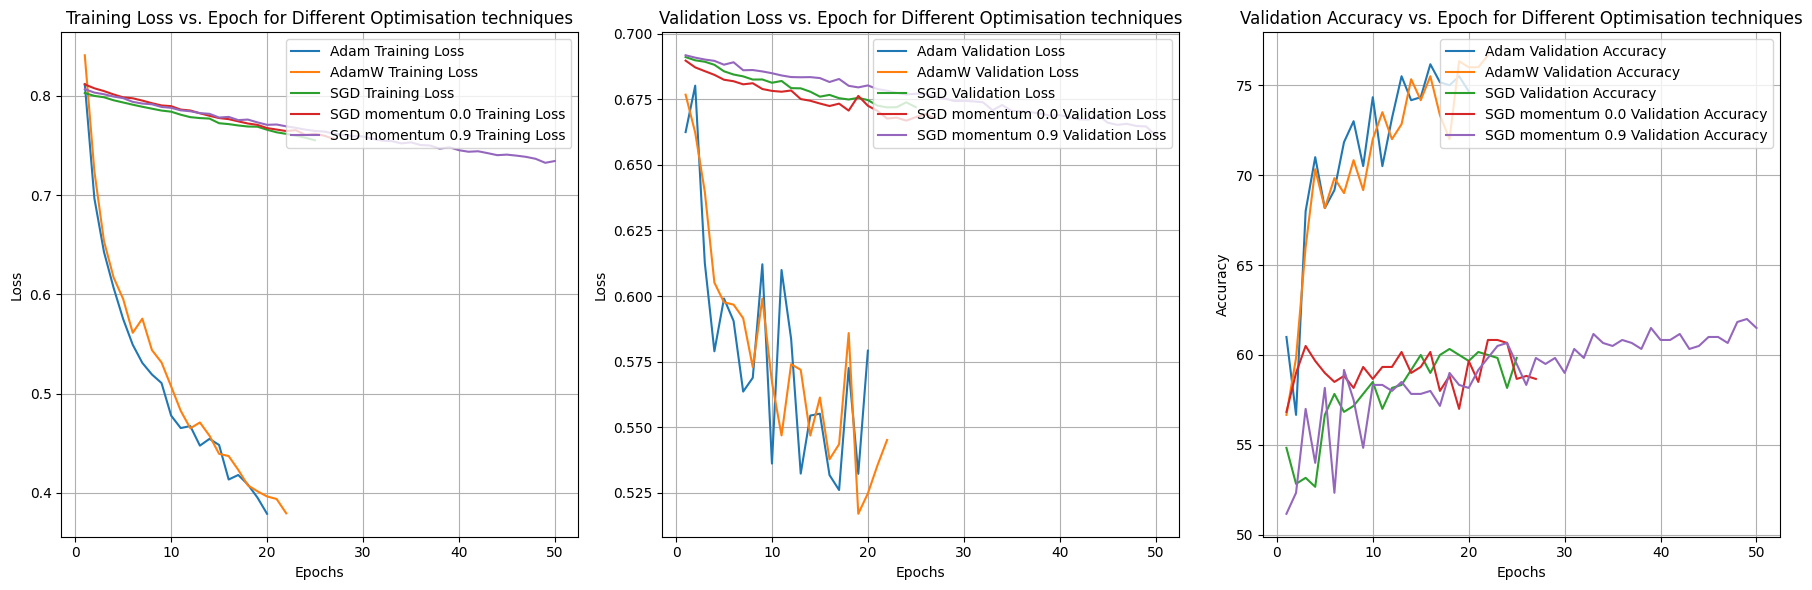

In [277]:
plt.figure(figsize=(18, 6))

# Training Loss
plt.subplot(131)
for opt_name in train_losses_dict:
    plt.plot(range(1, len(train_losses_dict[opt_name]) + 1), train_losses_dict[opt_name], label=f'{opt_name} Training Loss')
plt.title("Training Loss vs. Epoch for Different Optimisation techniques")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)

# Validation Loss
plt.subplot(132)
for opt_name in val_losses_dict:
    plt.plot(range(1, len(val_losses_dict[opt_name]) + 1), val_losses_dict[opt_name], label=f'{opt_name} Validation Loss')
plt.title("Validation Loss vs. Epoch for Different Optimisation techniques")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)

# Validation Accuracy
plt.subplot(133)
for opt_name in val_accuracies_dict:
    plt.plot(range(1, len(val_accuracies_dict[opt_name]) + 1), val_accuracies_dict[opt_name], label=f'{opt_name} Validation Accuracy')
plt.title("Validation Accuracy vs. Epoch for Different Optimisation techniques")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

The experiment gives us as the most efficient result the Adam optimization technique, as can be seen in the plot.

- experiment with different dropout rates: we have five different options:
    - Dropout rate 0.00;
    - Dropout rate 0.25;
    - Dropout rate 0.50;
    - Dropout rate 0.75;
    - Dropout rate 1.00.


In [278]:
# Different dropout rates
dropout_rates = [0.0, 0.25, 0.5, 0.75, 1.0]
dropout_results = {}

for rate in dropout_rates:
    model = CNN(dropout_rate=rate, pool_kernel=3, pool_stride=2).to(device)  
    dropout_results[rate] = model

train_losses_dict = {}
val_losses_dict = {}
val_accuracies_dict = {}

for drop_name, model in dropout_results.items():
    print(f"Training with dropout rate {drop_name}...")
    
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    
    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, regularization_type='L1', epochs=50)
    
    train_losses_dict[drop_name] = train_losses
    val_losses_dict[drop_name] = val_losses
    val_accuracies_dict[drop_name] = val_accuracies


Training with dropout rate 0.0...
Epoch 1, Training Loss: 0.8455, Validation Loss: 0.6851, Validation Accuracy: 57.00%
Epoch 2, Training Loss: 0.7230, Validation Loss: 0.6578, Validation Accuracy: 62.00%
Epoch 3, Training Loss: 0.6723, Validation Loss: 0.6400, Validation Accuracy: 61.17%
Epoch 4, Training Loss: 0.6433, Validation Loss: 0.6138, Validation Accuracy: 66.67%
Epoch 5, Training Loss: 0.5977, Validation Loss: 0.6101, Validation Accuracy: 67.83%
Epoch 6, Training Loss: 0.6020, Validation Loss: 0.5772, Validation Accuracy: 69.83%
Epoch 7, Training Loss: 0.5643, Validation Loss: 0.6007, Validation Accuracy: 68.83%
Epoch 8, Training Loss: 0.5446, Validation Loss: 0.5737, Validation Accuracy: 70.17%
Epoch 9, Training Loss: 0.5185, Validation Loss: 0.5568, Validation Accuracy: 71.67%
Epoch 10, Training Loss: 0.5052, Validation Loss: 0.5627, Validation Accuracy: 71.83%
Epoch 11, Training Loss: 0.4888, Validation Loss: 0.5431, Validation Accuracy: 73.33%
Epoch 12, Training Loss: 0.46

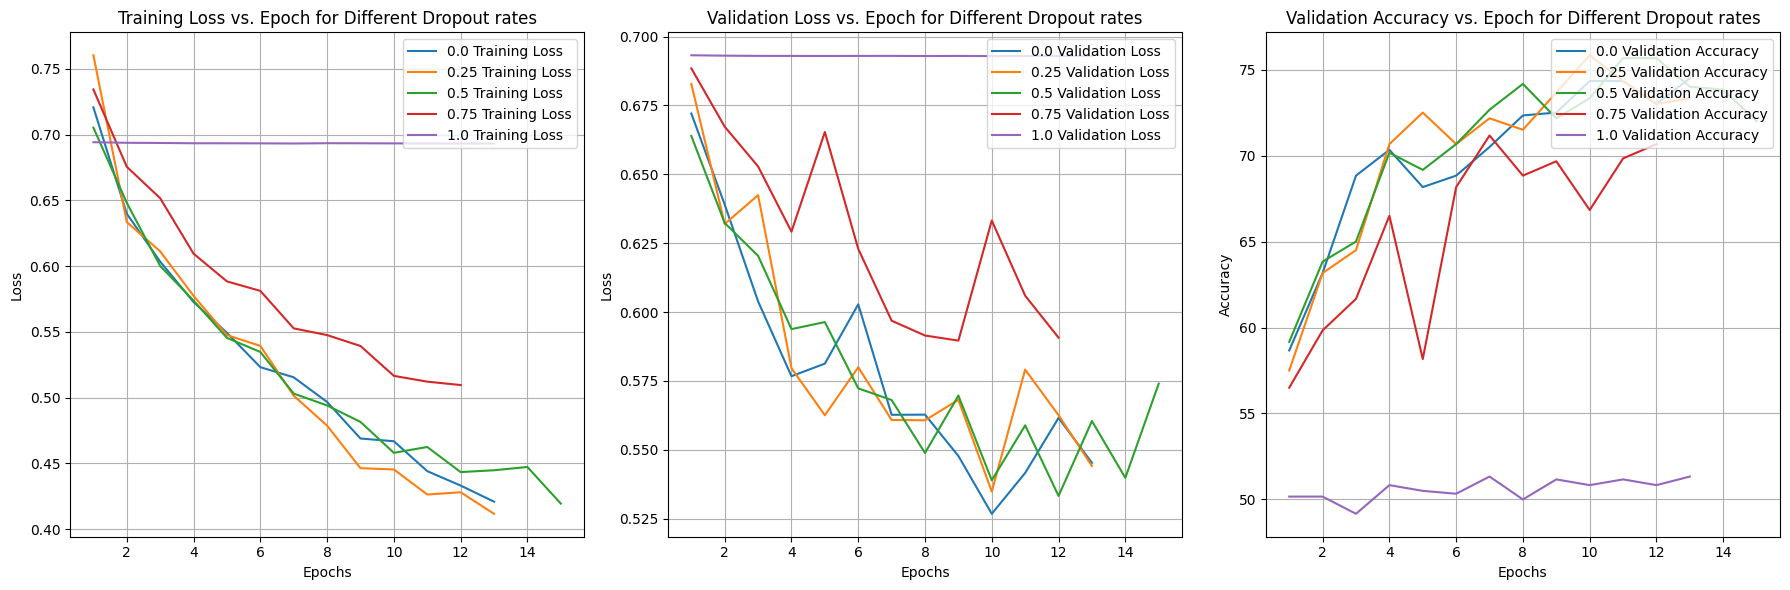

In [267]:
plt.figure(figsize=(18, 6))

# Training Loss
plt.subplot(131)
for drop_name in train_losses_dict:
    plt.plot(range(1, len(train_losses_dict[drop_name]) + 1), train_losses_dict[drop_name], label=f'{drop_name} Training Loss')
plt.title("Training Loss vs. Epoch for Different Dropout rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)

# Validation Loss
plt.subplot(132)
for drop_name in val_losses_dict:
    plt.plot(range(1, len(val_losses_dict[drop_name]) + 1), val_losses_dict[drop_name], label=f'{drop_name} Validation Loss')
plt.title("Validation Loss vs. Epoch for Different Dropout rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)

# Validation Accuracy
plt.subplot(133)
for drop_name in val_accuracies_dict:
    plt.plot(range(1, len(val_accuracies_dict[drop_name]) + 1), val_accuracies_dict[drop_name], label=f'{drop_name} Validation Accuracy')
plt.title("Validation Accuracy vs. Epoch for Different Dropout rates")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

The experiment gives us as the most efficient result the dropout rate equals to 0.25, as can be seen in the graph.

In [269]:
# Step 5: Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    misclassified = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    return misclassified if misclassified else []

misclassified_samples = evaluate_model(model, test_loader)

Test Accuracy: 49.50%


## Final model after experiment

So, for conclusion, the final model CNN has as addition:
- a Max Pooling layer with kernel size equals to 3 and stride size equals to 2;
- An L1 regularization;
- AdamW optimization;
- Dropout rate of 0.25.

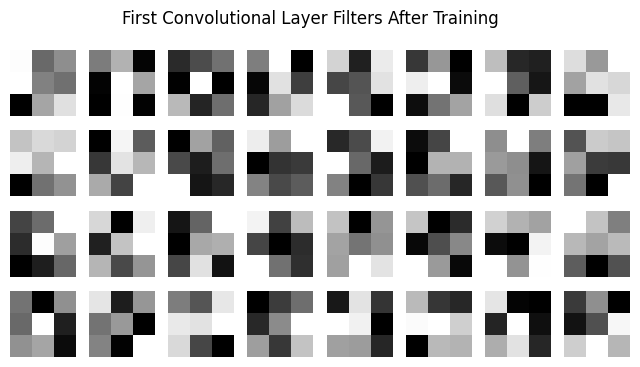

In [270]:
# Step 6: Check Results
# a. Plot first convolutional layer filters before and after training

def plot_filters(layer, title):
    filters = layer.weight.data.cpu().numpy()
    fig, axes = plt.subplots(4, 8, figsize=(8,4))
    for i, ax in enumerate(axes.flat):
        if i < filters.shape[0]:
            ax.imshow(filters[i, 0, :, :], cmap='gray')
            ax.axis('off')
    plt.suptitle(title)
    plt.show()

plot_filters(model.conv1, "First Convolutional Layer Filters After Training")


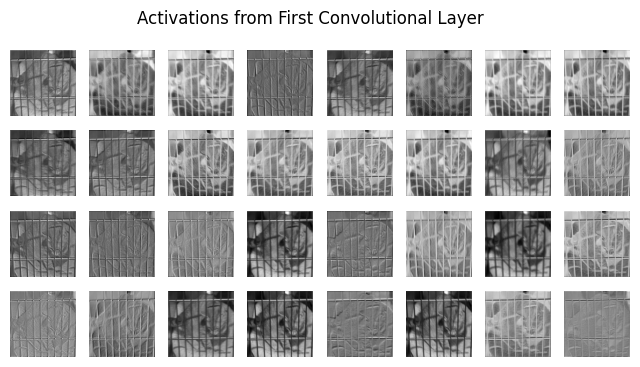

In [271]:
# b. Feed an image to the first convolutional layer and plot activations
def plot_activations(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        activation = model.conv1(image).cpu().numpy()
    fig, axes = plt.subplots(4, 8, figsize=(8,4))
    for i, ax in enumerate(axes.flat):
        if i < activation.shape[1]:
            ax.imshow(activation[0, i, :, :], cmap='gray')
            ax.axis('off')
    plt.suptitle("Activations from First Convolutional Layer")
    plt.show()

plot_activations(model, test_dataset[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.5764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the val

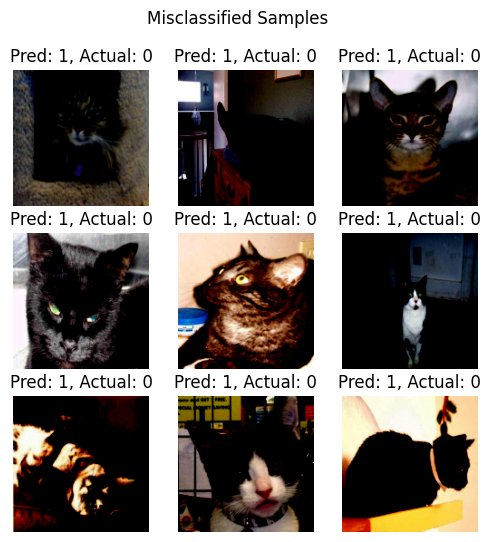

In [272]:
# c. Plot some incorrectly classified images
def plot_misclassified(samples):
    if not samples:
        print("No misclassified samples found.")
        return
    
    fig, axes = plt.subplots(3, 3, figsize=(6,6))
    
    for i, ax in enumerate(axes.flat):
        if i < len(samples):
            img, pred, actual = samples[i]
            img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
            ax.imshow(img)
            ax.set_title(f"Pred: {pred}, Actual: {actual}")
            ax.axis('off')
    
    plt.suptitle("Misclassified Samples")
    plt.show()

plot_misclassified(misclassified_samples)


## Issue with eperiment

However, the choice of all these configurations are based on a sequential experiment meaning that changing the order of the configuration, the result will probably change. So, for a better experiment, we decide to perform all the possible combination of the configuration of the model: this I shingly expensive from a time point of view since it will be 120 combinations. The results are highly difficult to visualize: we tried with a parallel lines plot even if it is not a suitable configuration. 


In [ ]:
# Configurations for pooling layers, regularization, optimizers, dropout rates, momentum
pooling_options = ['max', 'avg']
regularization_options = ['L1', 'L2', 'None']
optimizer_options = ['Adam', 'AdamW', 'SGD']
dropout_rates = [0.0, 0.25, 0.5, 0.75]
momentum_values = [0.0, 0.9]

results = {}  # Store results for different configurations

for pooling in pooling_options:
    for reg in regularization_options:
        for opt in optimizer_options:
            for dropout in dropout_rates:
                for momentum in momentum_values:
                    model = CNN(pool_type=pooling, dropout_rate=dropout).to(device)
                    criterion = nn.CrossEntropyLoss()
                    
                    if opt == 'SGD':
                        optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=momentum)  # SGD with momentum
                    elif opt == 'Adam':
                        optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adam optimizer, no momentum
                    elif opt == 'AdamW':
                        optimizer = optim.AdamW(model.parameters(), lr=0.0005)  # AdamW optimizer, no momentum

                    # Train the model with the current configuration
                    print(f"Training with {pooling} pooling, {reg} regularization, {opt} optimizer, {dropout} dropout, {momentum} momentum...")
                    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

                    # Store the results
                    results[(pooling, reg, opt, dropout, momentum)] = {
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'val_accuracies': val_accuracies
                    }


Training with max pooling, L1 regularization, Adam optimizer, 0.0 dropout, 0.0 momentum...
Epoch 1, Training Loss: 0.7472, Validation Loss: 0.6708, Validation Accuracy: 58.00%
Epoch 2, Training Loss: 0.6256, Validation Loss: 0.6345, Validation Accuracy: 67.67%
Epoch 3, Training Loss: 0.5553, Validation Loss: 0.6578, Validation Accuracy: 63.67%
Epoch 4, Training Loss: 0.4650, Validation Loss: 0.5994, Validation Accuracy: 69.17%
Epoch 5, Training Loss: 0.3500, Validation Loss: 0.6486, Validation Accuracy: 68.00%
Training with max pooling, L1 regularization, Adam optimizer, 0.0 dropout, 0.9 momentum...
Epoch 1, Training Loss: 0.7458, Validation Loss: 0.6653, Validation Accuracy: 60.50%
Epoch 2, Training Loss: 0.6354, Validation Loss: 0.6185, Validation Accuracy: 66.67%
Epoch 3, Training Loss: 0.5479, Validation Loss: 0.6234, Validation Accuracy: 67.33%
Epoch 4, Training Loss: 0.4146, Validation Loss: 0.6380, Validation Accuracy: 65.67%
Epoch 5, Training Loss: 0.2938, Validation Loss: 0.72

## Bonus track

In [ ]:
import timm

resnet_model = timm.create_model('resnet18', pretrained=True, num_classes=2).to(device)
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Data loading
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

resnet_train_dataset = datasets.ImageFolder(root="/Users/dmensorio/Desktop/Università Daniele/Third Year/AI506 - Advanced Machine Learning/projects/project 1/catdog_data/train", 
                                    transform=resnet_transform)
resnet_train_loader = DataLoader(resnet_train_dataset, batch_size=32, shuffle=True)

resnet_test_dataset = datasets.ImageFolder(root="/Users/dmensorio/Desktop/Università Daniele/Third Year/AI506 - Advanced Machine Learning/projects/project 1/catdog_data/test", 
                                    transform=resnet_transform)
resnet_test_loader = DataLoader(resnet_test_dataset, batch_size=32, shuffle=False)

resnet_val_dataset = datasets.ImageFolder(root="/Users/dmensorio/Desktop/Università Daniele/Third Year/AI506 - Advanced Machine Learning/projects/project 1/catdog_data/validation", 
                                    transform=resnet_transform)
resnet_val_loader = DataLoader(resnet_val_dataset, batch_size=32, shuffle=False)

# 5. Train and evaluate
print("Training ResNet18..")
train_losses, val_losses, val_acc = train_model(
    resnet_model,
    resnet_train_loader,
    resnet_val_loader,  
    criterion,
    resnet_optimizer,
    epochs=10
)

print(f"\nResNet18 Test Accuracy: {evaluate_model(resnet_model, resnet_test_loader):.2f}%")

Training ResNet18..
Epoch 1/10, Train Loss: 0.5723, Val Loss: 0.4211, Val Acc: 94.67%
Epoch 2/10, Train Loss: 0.2988, Val Loss: 0.1840, Val Acc: 96.50%
Epoch 3/10, Train Loss: 0.1368, Val Loss: 0.1083, Val Acc: 97.17%
Epoch 4/10, Train Loss: 0.0771, Val Loss: 0.0812, Val Acc: 97.50%
Epoch 5/10, Train Loss: 0.0465, Val Loss: 0.0684, Val Acc: 97.67%
Epoch 6/10, Train Loss: 0.0301, Val Loss: 0.0574, Val Acc: 98.17%
Epoch 7/10, Train Loss: 0.0256, Val Loss: 0.0516, Val Acc: 98.00%
Epoch 8/10, Train Loss: 0.0220, Val Loss: 0.0513, Val Acc: 98.17%
Epoch 9/10, Train Loss: 0.0116, Val Loss: 0.0543, Val Acc: 97.83%
Epoch 10/10, Train Loss: 0.0102, Val Loss: 0.0527, Val Acc: 98.17%

ResNet18 Test Accuracy: 98.75%


The pretrained ResNet18 model significantly outperforms the custom CNN in terms of training efficiency, validation accuracy, and test accuracy. ResNet18 achieves 98.75% test accuracy, while the custom CNN reaches only 72.00%, indicating better feature extraction and generalization in the pretrained model.

The custom CNN struggles with higher training and validation loss, suggesting limited learning capacity due to its shallower architecture and possible suboptimal hyperparameters. In contrast, ResNet18 shows faster convergence and lower loss, proving the effectiveness of transfer learning for this classification task.

Overall, pretrained deep architectures like ResNet18 offer superior performance compared to training a small CNN from scratch. Improvements to the custom CNN, such as deeper layers, better regularization, and optimized hyperparameters, would be necessary to bridge the performance gap.

# NOTE

ChatGPT has been employed as a reference tool for the conceptualization and generation of the image plots, serving as a foundational resource in the development of their narrative structure and visual composition.